In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

data = pd.read_csv('news_dataset/uci-news-aggregator.csv', usecols=['TITLE', 'CATEGORY'])
#M class has way less data than the orthers, thus the classes are unbalanced.
data.CATEGORY.value_counts()

#I do aspire here to have balanced classes
num_of_categories = 45000
shuffled = data.reindex(np.random.permutation(data.index))
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]
concated = pd.concat([e,b,t,m], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

#One-hot encode the lab
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=4)
print(labels[:10])
if 'CATEGORY' in concated.keys():
    concated.drop(['CATEGORY'], axis=1)
'''
 [1. 0. 0. 0.] e
 [0. 1. 0. 0.] b
 [0. 0. 1. 0.] t
 [0. 0. 0. 1.] m
'''

n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['TITLE'].values)
sequences = tokenizer.texts_to_sequences(concated['TITLE'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.8))
model.add(LSTM(128, dropout=0.8, recurrent_dropout=0.8))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])


accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
    
model1 = Sequential()
model1.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model1.add(SpatialDropout1D(0.3))
model1.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(LSTMs(implementation= 1, units=64,
                    activation='tanh' ,return_sequences=True,dropout=0.2, recurrent_dropout=0.3,
                    input_shape=X_train.shape[1:], model='LSTM5a'))
model1.add(Dropout(0.2))
model1.add(LSTMs(implementation= 1, units=64,
                    activation='tanh' ,dropout=0.2, recurrent_dropout=0.3,
                    input_shape=X_train.shape[1:], model='LSTM6'))
model1.add(Dropout(0.2))
model1.add(Dense(4, activation='sigmoid'))


#model.add(lstmi5a)
#model.add(lstmi6)
#model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
#model.add(x1)
#model.add(x2)


#adam=Adam(lr=0.1, beta_1=0.9, beta_2=0.99, epsilon=1e-05, decay=0)
adam=Adam(lr=-0.004)
model1.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
print(model1.summary())
#history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
history1 = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[exp_loss()])
#history= model.fit(X_train, y_train,
  #                        batch_size=batch_size,
   #                       epochs=epochs,
     #                      verbose=1,
      #                    validation_split=0.2)

accr = model1.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc benchmark')
plt.plot(epochs, val_acc, 'b', label='Validation acc benchmark')
plt.title('Training and validation accuracy benchmark model')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss benchmark')
plt.plot(epochs, val_loss, 'b', label='Validation loss benchmark')
plt.title('Training and validation loss benchmark model')
plt.legend()

plt.figure()

plt.plot(epochs, acc1, 'ro', label='Training acc Modified')
plt.plot(epochs, val_acc1, 'r', label='Validation acc Modified')
plt.title('Training and validation accuracy Modified model')
plt.legend()

plt.figure()

plt.plot(epochs, loss1, 'ro', label='Training loss Modified')
plt.plot(epochs, val_loss1, 'r', label='Validation loss Modified')
plt.title('Training and validation loss Modified model')
plt.legend()

plt.show()


txt = ["Regular fast food eating linked to fertility issues in women"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

14811     0
142091    3
131510    2
113079    2
18305     0
141371    3
112972    2
131441    2
112007    2
77224     1
Name: LABEL, dtype: int64
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
Found 51949 unique tokens.
((135000, 130), (135000, 4), (45000, 130), (45000, 4))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 1,156,100
Tra

NameError: name 'Conv1D' is not defined

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 130, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 130, 64)           24640     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 65, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 65, 64)            12352     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 32, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 32, 64)            12352     
__________

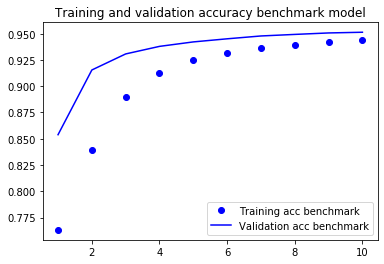

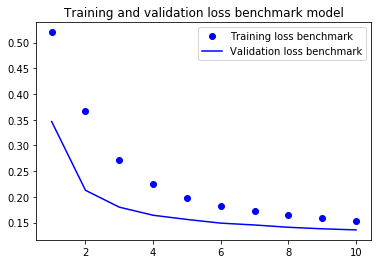

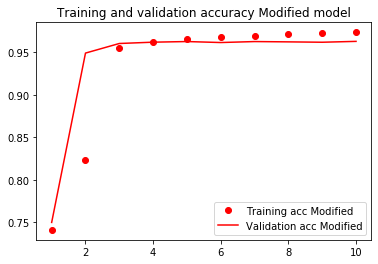

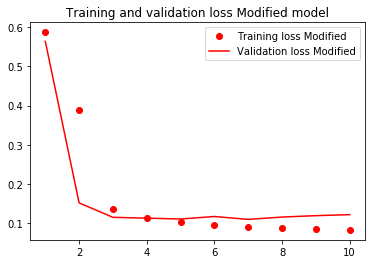

[[5.4902449e-04 1.9111848e-03 1.1403543e-03 9.9639940e-01]] health


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Input, GlobalMaxPooling1D
from slim21 import LSTMs
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.optimizers import RMSprop, SGD, Adam ,Adadelta
from keras.callbacks import Callback
from keras import backend as K

class exp_loss(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.logs = []    
    def on_epoch_end(self,epoch,logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        prev_ep_loss = self.val_losses[self.i]
        self.i += 1
        prev_lr = float(K.get_value(self.model.optimizer.lr))
        upd_lr = prev_lr * np.exp(prev_ep_loss)
        K.set_value(self.model.optimizer.lr, upd_lr)
        
        print('Test Loss:', self.val_losses)
        print('Current Epoch = ', self.i+1)
        print('Previous Learning Rate:', prev_lr)
        print('Updated Learning Rate:', upd_lr) 

model1 = Sequential()
model1.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model1.add(SpatialDropout1D(0.3))
model1.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(LSTMs(implementation= 1, units=64,
                    activation='tanh' ,return_sequences=True,dropout=0.2, recurrent_dropout=0.3,
                    input_shape=X_train.shape[1:], model='LSTM5a'))
model1.add(Dropout(0.2))
model1.add(LSTMs(implementation= 1, units=64,
                    activation='tanh' ,dropout=0.2, recurrent_dropout=0.3,
                    input_shape=X_train.shape[1:], model='LSTM6'))
model1.add(Dropout(0.2))
model1.add(Dense(4, activation='sigmoid'))


#model.add(lstmi5a)
#model.add(lstmi6)
#model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
#model.add(x1)
#model.add(x2)


#adam=Adam(lr=0.1, beta_1=0.9, beta_2=0.99, epsilon=1e-05, decay=0)
adam=Adam(lr=-0.004)
model1.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
print(model1.summary())
#history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
history1 = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[exp_loss()])
#history= model.fit(X_train, y_train,
  #                        batch_size=batch_size,
   #                       epochs=epochs,
     #                      verbose=1,
      #                    validation_split=0.2)

accr = model1.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc benchmark')
plt.plot(epochs, val_acc, 'b', label='Validation acc benchmark')
plt.title('Training and validation accuracy benchmark model')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss benchmark')
plt.plot(epochs, val_loss, 'b', label='Validation loss benchmark')
plt.title('Training and validation loss benchmark model')
plt.legend()

plt.figure()

plt.plot(epochs, acc1, 'ro', label='Training acc Modified')
plt.plot(epochs, val_acc1, 'r', label='Validation acc Modified')
plt.title('Training and validation accuracy Modified model')
plt.legend()

plt.figure()

plt.plot(epochs, loss1, 'ro', label='Training loss Modified')
plt.plot(epochs, val_loss1, 'r', label='Validation loss Modified')
plt.title('Training and validation loss Modified model')
plt.legend()

plt.show()


txt = ["Regular fast food eating linked to fertility issues in women"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])


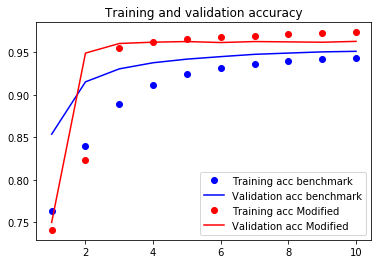

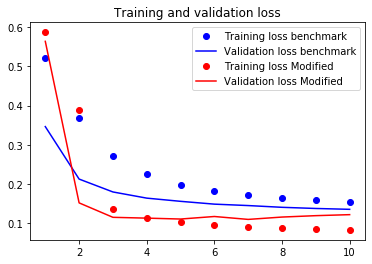

In [6]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc benchmark')
plt.plot(epochs, val_acc, 'b', label='Validation acc benchmark')
plt.plot(epochs, acc1, 'ro', label='Training acc Modified')
plt.plot(epochs, val_acc1, 'r', label='Validation acc Modified')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss benchmark')
plt.plot(epochs, val_loss, 'b', label='Validation loss benchmark')
plt.plot(epochs, loss1, 'ro', label='Training loss Modified')
plt.plot(epochs, val_loss1, 'r', label='Validation loss Modified')
plt.title('Training and validation loss')
plt.legend()


plt.show()